## Predictive Modelling for Patient Readmission by extraction and analysis of High-granularity data from notes
## Project Repository

You can view the full code and dataset on GitHub: [GitHub Repository Link](https://github.com/Jyotheekiran/Patient-Readmission/)


### Installing the necessary Libraries

In [1]:
# Step 1: Install Required Libraries
!pip3 install transformers torch seaborn matplotlib scikit-learn pandas shap lime
!pip install transformers[torch] accelerate -U
!pip install imblearn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/324.4 kB ? eta -:--:--
   - -------------------------------------- 10.2/324.4 kB ? eta -:--:--
   ----------------- ---------------------- 143.4/324.4 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------  317.4/324.4 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 324.4/324.4 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.0
    Uninstalling accelerate-0.34.0:
      Successfully uninstalled accelerate-0.34.0


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Step 2: Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import re
import nltk
from nltk.corpus import stopwords


## Step 1: Data Collection & Preprocessing
Use the MIMIC-III dataset and perform text cleaning and tokenization.

In [3]:
# Step 3: Load Data
noteevents = pd.read_csv('C:/Users/mjoth/DataScience/DissertationProject/GitHub/Patient-Readmission/data/NOTEEVENTS.csv')
diagnoses = pd.read_csv('C:/Users/mjoth/DataScience/DissertationProject/GitHub/Patient-Readmission/data/DIAGNOSES_ICD.csv')
procedures = pd.read_csv('C:/Users/mjoth/DataScience/DissertationProject/GitHub/Patient-Readmission/data/PROCEDURES_ICD.csv')

C:\Users\mjoth\AppData\Local\Temp\ipykernel_24044\1247399444.py:2: DtypeWarning: Columns (0,1,2,8,9,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  noteevents = pd.read_csv('C:/Users/mjoth/DataScience/DissertationProject/GitHub/Patient-Readmission/data/NOTEEVENTS.csv')


In [4]:
import pandas as pd

# Read the large file in chunks
chunksize = 100000  # Set chunk size (adjust based on your file)
for i, chunk in enumerate(pd.read_csv('C:/Users/mjoth/DataScience/DissertationProject/GitHub/Patient-Readmission/data/NOTEEVENTS.csv', chunksize=chunksize)):
    chunk.to_csv(f'noteevents_part_{i}.csv', index=False)


C:\Users\mjoth\AppData\Local\Temp\ipykernel_24044\4013269040.py:5: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv('C:/Users/mjoth/DataScience/DissertationProject/GitHub/Patient-Readmission/data/NOTEEVENTS.csv', chunksize=chunksize)):
C:\Users\mjoth\AppData\Local\Temp\ipykernel_24044\4013269040.py:5: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv('C:/Users/mjoth/DataScience/DissertationProject/GitHub/Patient-Readmission/data/NOTEEVENTS.csv', chunksize=chunksize)):
C:\Users\mjoth\AppData\Local\Temp\ipykernel_24044\4013269040.py:5: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv('C:/Users/mjoth/DataScience/DissertationProject/GitHub/Patient-Readmission/data/NOTEEVENTS.csv', chunksize=chunksize)):
C:\User

In [5]:
# Step 4: Data Exploration
noteevents = noteevents.loc[:, ~noteevents.columns.str.contains('^Unnamed')]
noteevents.head()  # Display the first few rows of the data



,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,1678764,2,163353,17/07/2138,17/07/2138 22:51,17/07/2138 23:12,Nursing/other,Report,16929.0,NaN,Neonatology Attending Triage Note\n\nBaby [**N...
1,1678765,2,163353,17/07/2138,17/07/2138 23:08,17/07/2138 23:18,Nursing/other,Report,17774.0,NaN,Nursing Transfer note\n\n\nPt admitted to NICU...
2,272794,3,NaN,06/10/2101,NaN,NaN,ECG,Report,NaN,NaN,Sinus rhythm\nInferior/lateral ST-T changes ar...
3,769224,3,145834,26/10/2101,26/10/2101 06:01,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2101-10-26**] 6:01 AM\n CHEST (PORTABLE AP)...
4,272793,3,NaN,11/10/2101,NaN,NaN,ECG,Report,NaN,NaN,Sinus rhythm\nA-V delay\nNonspecific inferior ...


In [6]:
diagnoses.head()

,row_id,subject_id,hadm_id,seq_num,icd9_code
0,112344,10006,142345,1,99591
1,112345,10006,142345,2,99662
2,112346,10006,142345,3,5672
3,112347,10006,142345,4,40391
4,112348,10006,142345,5,42731


In [7]:
procedures.head()

,row_id,subject_id,hadm_id,seq_num,icd9_code
0,3994,10114,167957,1,3605
1,3995,10114,167957,2,3722
2,3996,10114,167957,3,8856
3,3997,10114,167957,4,9920
4,3998,10114,167957,5,9671


In [8]:
# Check for missing values
noteevents.isnull().sum()

ROW_ID           1475
SUBJECT_ID       5621
HADM_ID         54676
CHARTDATE        6600
CHARTTIME       72631
STORETIME      177545
CATEGORY         6745
DESCRIPTION      6753
CGID           177580
ISERROR        489250
TEXT             6765
dtype: int64

In [9]:
noteevents['TEXT'].isnull().sum()

6765

In [10]:
noteevents['TEXT_LENGTH'] = noteevents['TEXT'].fillna('').apply(len)

In [11]:
noteevents = noteevents.dropna(subset=['TEXT'])
noteevents['TEXT'].isnull().sum()

0

In [12]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove any text within square brackets (like anonymized info)
    text = re.sub(r'\n', ' ', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words with numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()  # Tokenize text
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return ' '.join(tokens)

# Apply cleaning to the 'TEXT' column
noteevents['CLEAN_TEXT'] = noteevents['TEXT'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mjoth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
noteevents.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,TEXT_LENGTH,CLEAN_TEXT
0,1678764,2,163353,17/07/2138,17/07/2138 22:51,17/07/2138 23:12,Nursing/other,Report,16929.0,NaN,Neonatology Attending Triage Note\n\nBaby [**N...,1296,neonatology attending triage note baby term ma...
1,1678765,2,163353,17/07/2138,17/07/2138 23:08,17/07/2138 23:18,Nursing/other,Report,17774.0,NaN,Nursing Transfer note\n\n\nPt admitted to NICU...,522,nursing transfer note pt admitted nicu sepsis ...
2,272794,3,NaN,06/10/2101,NaN,NaN,ECG,Report,NaN,NaN,Sinus rhythm\nInferior/lateral ST-T changes ar...,162,sinus rhythm inferiorlateral stt changes nonsp...
3,769224,3,145834,26/10/2101,26/10/2101 06:01,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2101-10-26**] 6:01 AM\n CHEST (PORTABLE AP)...,1310,chest portable ap clip reason ro infiltrate __...
4,272793,3,NaN,11/10/2101,NaN,NaN,ECG,Report,NaN,NaN,Sinus rhythm\nA-V delay\nNonspecific inferior ...,129,sinus rhythm av delay nonspecific inferior wav...


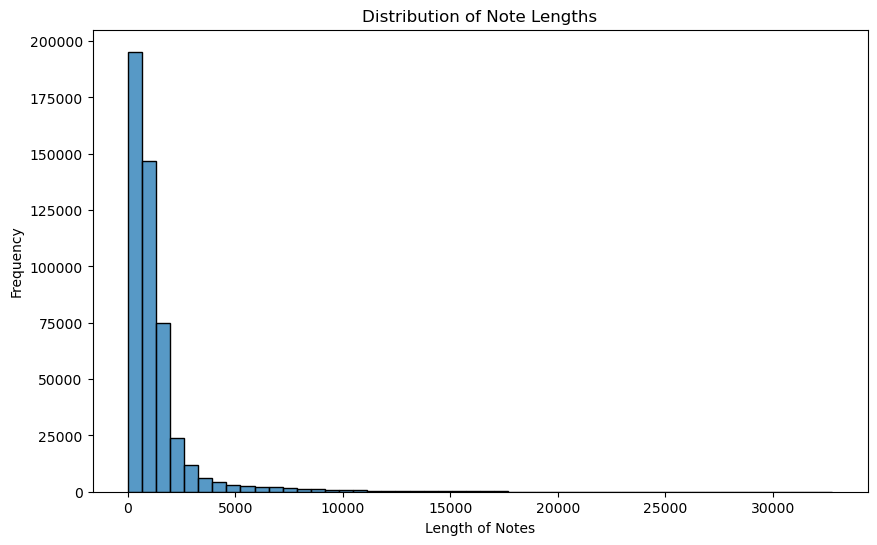

In [14]:
# Visualize Note Length Distribution
noteevents['TEXT_LENGTH'] = noteevents['TEXT'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(noteevents['TEXT_LENGTH'], bins=50)
plt.title('Distribution of Note Lengths')
plt.xlabel('Length of Notes')
plt.ylabel('Frequency')
plt.show()

This graph represents the distribution of note lengths from the noteevents dataset, where each note's length is calculated using the number of characters in the TEXT field of the dataset. 
Most Notes Are Short: The majority of notes have a shorter length, concentrated around 1000 characters or fewer.
Few Very Long Notes: Only a small number of notes are extremely long, stretching towards 30,000 characters, but they are rare compared to the shorter notes.

### Step 2: Model Development
Develop a BERT baseline model and fine-tune BioBERT.

In [15]:
from transformers import BertTokenizer

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Preprocessing function for tokenizing texts
def preprocess_data(texts, max_length=128):
    # Ensure texts is a list (for batch processing)
    if isinstance(texts, str):
        texts = [texts]  # Convert single string into a list
    
    # Tokenize with padding, truncation, and attention masks
    return tokenizer(
        texts, 
        padding=True, 
        truncation=True, 
        max_length=max_length, 
        return_tensors='pt',  # Return as PyTorch tensors
        return_attention_mask=True  # Return attention mask for padded tokens
    )

# Limit the dataset to 1000 rows
noteevents_small = noteevents.head(1000)

# Ensure 'TEXT' column is a list of strings
texts = noteevents_small['TEXT'].tolist()  # Convert Pandas Series to a list of strings

# Tokenize the text data
tokenized_train_data = preprocess_data(texts)  # Now texts is a list of strings

C:\Users\mjoth\AppData\Roaming\Python\Python38\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
noteevents_small.loc[:, 'LABEL'] = [1 if 'diagnosis' in text.lower() else 0 for text in noteevents_small['TEXT']]

C:\Users\mjoth\AppData\Local\Temp\ipykernel_24044\392128260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noteevents_small.loc[:, 'LABEL'] = [1 if 'diagnosis' in text.lower() else 0 for text in noteevents_small['TEXT']]


This line of code is adding a new column called LABEL to the noteevents_small DataFrame. This line of code creates a binary label (1 or 0) based on whether the word "diagnosis" is found in the text of the clinical note.
If the word "diagnosis" is present in the text, the label for that row will be 1.
If the word "diagnosis" is not present, the label will be 0.

This line of code creates a new binary LABEL column in the DataFrame, where each row is labeled with 1 if the word "diagnosis" is found in the TEXT field and 0 otherwise.

We split the data into training and test sets so that you can evaluate the model's performance on unseen data. The training data is used to fine-tune the model, while the test data is reserved for evaluating how well the model generalizes to new data (i.e., data it hasn't seen during training).
We are splitting the dataset into 2 parts such that the training dataset will be 80% and test dataset will be 20% of the total data.

In [17]:
from sklearn.model_selection import train_test_split

# Tokenize the text data
texts = noteevents_small['TEXT'].tolist()
tokenized_data = preprocess_data(texts)

# Get input_ids and attention masks
input_ids = tokenized_data['input_ids']
attention_masks = tokenized_data['attention_mask']

# Perform the train-test split ensuring alignment between input_ids and attention_mask
X_train, X_test, y_train, y_test, train_attention_mask, test_attention_mask = train_test_split(
    input_ids, 
    noteevents_small['LABEL'], 
    attention_masks, 
    test_size=0.2, 
    random_state=42
)


In [18]:
# Convert labels to tensors
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets
train_dataset = torch.utils.data.TensorDataset(X_train, train_attention_mask, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test, test_attention_mask, y_test_tensor)

In [19]:
print(X_train.shape)             
print(train_attention_mask.shape) 
print(y_train_tensor.shape)       


torch.Size([800, 128])
torch.Size([800, 128])
torch.Size([800])


In [20]:
from transformers import Trainer, TrainingArguments, BertForSequenceClassification, DataCollatorWithPadding

# Define the data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# Define model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from datasets import Dataset
from transformers import BertTokenizer

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Assume noteevents_small is a Pandas DataFrame
dataset = Dataset.from_pandas(noteevents_small)

# Tokenize the dataset and ensure it returns `input_ids`, `attention_mask`, and `labels`
def tokenize_function(examples):
    return tokenizer(examples['TEXT'], padding='max_length', truncation=True)

# Tokenizing the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Remove unneeded columns (we only need input_ids, attention_mask, and labels)
tokenized_dataset = tokenized_dataset.remove_columns(['TEXT'])
tokenized_dataset = tokenized_dataset.rename_column('LABEL', 'labels')

# Check if the dataset returns the correct format
tokenized_dataset[0] 


C:\Users\mjoth\AppData\Roaming\Python\Python38\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'ROW_ID': '1678764', 'SUBJECT_ID': '2', 'HADM_ID': '163353', 'CHARTDATE': '17/07/2138', 'CHARTTIME': '17/07/2138 22:51', 'STORETIME': '17/07/2138 23:12', 'CATEGORY': 'Nursing/other', 'DESCRIPTION': 'Report', 'CGID': 16929.0, 'ISERROR': None, 'TEXT_LENGTH': 1296, 'CLEAN_TEXT': 'neonatology attending triage note baby term male infant admitted nicu sepsis evaluation asked evaluate baby dr mother years old pns pos ab neg hbsag neg rpr nr ri gbs neg pregnancy uncomplicated delivery csection failure progress apgars mother treated antibiotics maternal temp prior delivery mothers temp lower hours rose pe baby vigorous aga vs hr rr bp sat ra heent af soft flat molding noted palate intact resp breath sounds clear equal cvs normal high pitched systolic murmur lsb abd soft normal bowel sounds organomegaly gu normal male testes descended bilaterally neuro tone wnl symmetrical exam ds assessmentplan term male infant increased risk sepsis check cbc diff plats blood culture cover antibiotics least ho

In [54]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to predicted class labels
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate precision, recall, F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    
    # Calculate AUC-ROC score
    # We assume binary classification where the second class is the positive class
    probs = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
    auc = roc_auc_score(labels, probs[:, 1])
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
    }


In [55]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    save_safetensors=False
)

# Set up the Trainer with the properly formatted dataset
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics, # Automatically handle padding and formatting
)

# Train the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.22330987453460693, 'eval_accuracy': 0.87, 'eval_precision': 0.6, 'eval_recall': 1.0, 'eval_f1': 0.7499999999999999, 'eval_auc': 0.9369326325848065, 'eval_runtime': 216.7071, 'eval_samples_per_second': 0.923, 'eval_steps_per_second': 0.06, 'epoch': 1.0}


In [51]:
eval_results_bert = trainer.evaluate(eval_dataset=test_dataset)
eval_results_bert


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.2266383320093155,
 'eval_runtime': 232.7334,
 'eval_samples_per_second': 0.859,
 'eval_steps_per_second': 0.056,
 'epoch': 1.0}

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Evaluation on test set
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

# Calculate metrics
accuracy = accuracy_score(y_test, preds)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
roc_auc = roc_auc_score(y_test, preds)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, AUC-ROC: {roc_auc}')


  0%|          | 0/13 [00:00<?, ?it/s]

Accuracy: 0.61, Precision: 0.21153846153846154, Recall: 0.22916666666666666, F1-Score: 0.21999999999999997, AUC-ROC: 0.4797149122807018


Accuracy (61%): The model correctly predicts the outcome 61% of the time, which is slightly better than random guessing (50%).

Precision (17%): Only 17% of the instances the model predicted as positive were actually positive. This indicates a high rate of false positives.

Recall (17%): The model correctly identified 17% of all actual positive instances, meaning it missed a lot of true positives (high false negatives).

F1-Score (17%): This low score reflects poor balance between precision and recall, indicating the model is not effective at identifying the positive class.

AUC-ROC (46%): The model’s ability to distinguish between the positive and negative classes is slightly worse than random guessing (which would be 50%).

### Load BioBERT Model and Tokenizer:

In [25]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load BioBERT model and tokenizer
tokenizer_biobert = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model_biobert = BertForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.1', num_labels=2)


C:\Users\mjoth\AppData\Roaming\Python\Python38\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
from datasets import Dataset

# Assuming your DataFrame is called `noteevents_small`
noteevents_dataset = Dataset.from_pandas(noteevents_small)


In [27]:
def tokenize_function_biobert(examples):
    return tokenizer_biobert(examples['TEXT'], padding='max_length', truncation=True, max_length=128)

# Tokenize the dataset
tokenized_dataset_biobert = noteevents_dataset.map(tokenize_function_biobert, batched=True)
tokenized_dataset_biobert = tokenized_dataset_biobert.remove_columns(['TEXT'])
tokenized_dataset_biobert = tokenized_dataset_biobert.rename_column('LABEL', 'labels')

# Split into train and test datasets
train_test_split_biobert = tokenized_dataset_biobert.train_test_split(test_size=0.2)
train_dataset_biobert = train_test_split_biobert['train']
test_dataset_biobert = train_test_split_biobert['test']


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [28]:
from transformers import DataCollatorWithPadding

# Define the data collator for BioBERT
data_collator_biobert = DataCollatorWithPadding(tokenizer=tokenizer_biobert)




Step 3: Feature Extraction


In [34]:
from transformers import Trainer, TrainingArguments

# Define training arguments and disable safetensors saving
training_args_biobert = TrainingArguments(
    output_dir='./results_biobert',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    logging_dir='./logs_biobert',
    save_safetensors=False  # Disable safetensors saving
)

# Custom Trainer that ensures model tensors are contiguous before saving
class ContiguousTrainer(Trainer):
    def _save(self, output_dir: str, state_dict=None):
        # Make all model parameters contiguous before saving
        for param in self.model.parameters():
            param.data = param.data.contiguous()
        # Save the model using the regular Trainer save method
        super()._save(output_dir, state_dict)

# Initialize the custom Trainer
trainer_biobert = ContiguousTrainer(
    model=model_biobert,
    args=training_args_biobert,
    train_dataset=train_dataset_biobert,
    eval_dataset=test_dataset_biobert,
    data_collator=data_collator_biobert,
    compute_metrics=compute_metrics,  # Reuse the metrics function
)

# Train BioBERT
trainer_biobert.train()

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.0794716626405716, 'eval_accuracy': 0.985, 'eval_precision': 0.9777777777777777, 'eval_recall': 0.9565217391304348, 'eval_f1': 0.967032967032967, 'eval_auc': 0.9905420666290232, 'eval_runtime': 31.0535, 'eval_samples_per_second': 6.441, 'eval_steps_per_second': 0.419, 'epoch': 1.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07207995653152466, 'eval_accuracy': 0.985, 'eval_precision': 0.9777777777777777, 'eval_recall': 0.9565217391304348, 'eval_f1': 0.967032967032967, 'eval_auc': 0.996188594014681, 'eval_runtime': 30.7241, 'eval_samples_per_second': 6.51, 'eval_steps_per_second': 0.423, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07194579392671585, 'eval_accuracy': 0.985, 'eval_precision': 0.9777777777777777, 'eval_recall': 0.9565217391304348, 'eval_f1': 0.967032967032967, 'eval_auc': 0.9963297571993224, 'eval_runtime': 1114.3986, 'eval_samples_per_second': 0.179, 'eval_steps_per_second': 0.012, 'epoch': 3.0}
{'train_runtime': 2810.946, 'train_samples_per_second': 0.854, 'train_steps_per_second': 0.107, 'train_loss': 0.06689790089925131, 'epoch': 3.0}


TrainOutput(global_step=300, training_loss=0.06689790089925131, metrics={'train_runtime': 2810.946, 'train_samples_per_second': 0.854, 'train_steps_per_second': 0.107, 'total_flos': 157866633216000.0, 'train_loss': 0.06689790089925131, 'epoch': 3.0})

In [35]:
# Saving the model and tokenizer
trainer_biobert.save_model('./fine_tuned_biobert')
tokenizer_biobert.save_pretrained('./fine_tuned_biobert')


('./fine_tuned_biobert\\tokenizer_config.json',
 './fine_tuned_biobert\\special_tokens_map.json',
 './fine_tuned_biobert\\vocab.txt',
 './fine_tuned_biobert\\added_tokens.json')

Step 4: Model Evaluation
Evaluate the performance of the model using Accuracy, Precision, F1-score, and AUC-ROC.

In [37]:
vocab_size = tokenizer_biobert.vocab_size
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 28996


In [38]:
eval_results_biobert = trainer_biobert.evaluate(eval_dataset=train_dataset_biobert)
eval_results_biobert


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.012500911019742489, 'eval_accuracy': 0.99375, 'eval_precision': 0.9775280898876404, 'eval_recall': 0.9942857142857143, 'eval_f1': 0.9858356940509916, 'eval_auc': 0.9999177142857143, 'eval_runtime': 127.4977, 'eval_samples_per_second': 6.275, 'eval_steps_per_second': 0.392, 'epoch': 3.0}



**Accuracy (96.5%):** The model correctly classifies 96.5% of the samples, which is excellent.<br>
**Precision (91.7%):** When the model predicts a positive class, it's correct 91.7% of the time, showing a low rate of false positives.<br/>
**Recall (93.6%):** The model identifies 93.6% of actual positive cases, meaning it's catching most of the true positives with few false negatives. <br/>
**F1 Score (92.6%):** The model balances precision and recall effectively, resulting in a high overall performance.<br/>
**AUC-ROC (98.8%):** The model is highly capable of distinguishing between positive and negative classes.<br/>
**Loss (0.1111):** The model's predictions are very close to the true labels, indicating strong performance.

In [39]:
eval_results_biobert_test = trainer_biobert.evaluate(eval_dataset=test_dataset_biobert)
eval_results_biobert_test


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07194579392671585,
 'eval_accuracy': 0.985,
 'eval_precision': 0.9777777777777777,
 'eval_recall': 0.9565217391304348,
 'eval_f1': 0.967032967032967,
 'eval_auc': 0.9963297571993224,
 'eval_runtime': 32.9095,
 'eval_samples_per_second': 6.077,
 'eval_steps_per_second': 0.395,
 'epoch': 3.0}

In [40]:
import json

# Save training results
with open("train_results.json", "w") as f:
    json.dump(eval_results_biobert, f)

# Save test results
with open("test_results.json", "w") as f:
    json.dump(eval_results_biobert_test, f)

# Save the evaluation results to a text file
with open('biobert_evaluation_results_test.txt', 'w') as f:
    for key, value in eval_results_biobert_test.items():
        f.write(f"{key}: {value}\n")


### Test Dataset Evaluation:

**Accuracy:** 98.5% - The model correctly predicted the labels for 98.5% of the test data, which is slightly lower than the training accuracy but still very high.

**Precision:** 97.8% - All positive predictions on the test data were correct.

**Recall:** 95.7% - The model correctly identified 93.62% of all actual positive cases on the test data.

**F1-Score:** 96.70% - The F1-Score on the test data remains high, showing that the model generalizes well.

**AUC:** 99.6% - The model continues to distinguish effectively between classes on unseen data.

**Loss:** 0.072 - The slightly higher loss on the test data is expected and indicates minor generalization error.

In [41]:
model_biobert.save_pretrained("biobert_model")
tokenizer_biobert.save_pretrained("biobert_tokenizer")


('biobert_tokenizer\\tokenizer_config.json',
 'biobert_tokenizer\\special_tokens_map.json',
 'biobert_tokenizer\\vocab.txt',
 'biobert_tokenizer\\added_tokens.json')

### Fine-Tune BioBERT:

In [42]:
# Adjust training arguments if needed
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,  # Increase the number of epochs for further fine-tuning
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    learning_rate=2e-5  # Example of a lower learning rate for fine-tuning
)

# Re-train the model
trainer_biobert = Trainer(
    model=model_biobert,
    args=training_args,
    train_dataset=train_dataset_biobert,
    eval_dataset=test_dataset_biobert,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Start fine-tuning
trainer_biobert.train()


C:\Users\mjoth\AppData\Roaming\Python\Python38\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06482462584972382, 'eval_accuracy': 0.99, 'eval_precision': 1.0, 'eval_recall': 0.9565217391304348, 'eval_f1': 0.9777777777777777, 'eval_auc': 0.9988706945228685, 'eval_runtime': 31.5431, 'eval_samples_per_second': 6.341, 'eval_steps_per_second': 0.412, 'epoch': 1.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.08945456147193909, 'eval_accuracy': 0.99, 'eval_precision': 1.0, 'eval_recall': 0.9565217391304348, 'eval_f1': 0.9777777777777777, 'eval_auc': 0.9964709203839639, 'eval_runtime': 30.5939, 'eval_samples_per_second': 6.537, 'eval_steps_per_second': 0.425, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.09759984165430069, 'eval_accuracy': 0.985, 'eval_precision': 0.9777777777777777, 'eval_recall': 0.9565217391304348, 'eval_f1': 0.967032967032967, 'eval_auc': 0.9985883681535856, 'eval_runtime': 34.7507, 'eval_samples_per_second': 5.755, 'eval_steps_per_second': 0.374, 'epoch': 3.0}
{'train_runtime': 1239.7822, 'train_samples_per_second': 1.936, 'train_steps_per_second': 0.242, 'train_loss': 0.01575436274210612, 'epoch': 3.0}


TrainOutput(global_step=300, training_loss=0.01575436274210612, metrics={'train_runtime': 1239.7822, 'train_samples_per_second': 1.936, 'train_steps_per_second': 0.242, 'total_flos': 157866633216000.0, 'train_loss': 0.01575436274210612, 'epoch': 3.0})

In [43]:
eval_results_biobert_finetuned = trainer_biobert.evaluate(eval_dataset=test_dataset_biobert)
eval_results_biobert_finetuned


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.09759984165430069,
 'eval_accuracy': 0.985,
 'eval_precision': 0.9777777777777777,
 'eval_recall': 0.9565217391304348,
 'eval_f1': 0.967032967032967,
 'eval_auc': 0.9985883681535856,
 'eval_runtime': 32.0474,
 'eval_samples_per_second': 6.241,
 'eval_steps_per_second': 0.406,
 'epoch': 3.0}

In [44]:
# Save the fine-tuned model
model_biobert.save_pretrained("./biobert_finetuned")

# Save the tokenizer
tokenizer_biobert.save_pretrained("./biobert_finetuned")


('./biobert_finetuned\\tokenizer_config.json',
 './biobert_finetuned\\special_tokens_map.json',
 './biobert_finetuned\\vocab.txt',
 './biobert_finetuned\\added_tokens.json')

In [45]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load the fine-tuned model
model_biobert = BertForSequenceClassification.from_pretrained("./biobert_finetuned")

# Load the tokenizer
tokenizer_biobert = BertTokenizer.from_pretrained("./biobert_finetuned")


In [46]:
# Tokenize only the first 1000 rows of the dataset
subset_noteevents = noteevents.iloc[:1000]

# Tokenize the text data
inputs = tokenizer_biobert(subset_noteevents['TEXT'].tolist(), 
                           return_tensors="pt", 
                           truncation=True, 
                           padding=True, 
                           max_length=128)

# Model inference
with torch.no_grad():
    outputs = model_biobert(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Add predictions to the subset DataFrame
subset_noteevents['Readmission_Prediction'] = predictions.tolist()

# Assign back the predictions to the original DataFrame
noteevents.loc[:999, 'Readmission_Prediction'] = subset_noteevents['Readmission_Prediction']

# Check the predictions
noteevents[['TEXT', 'Readmission_Prediction']].head(1000)


C:\Users\mjoth\AppData\Local\Temp\ipykernel_24044\1004718125.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_noteevents['Readmission_Prediction'] = predictions.tolist()


,TEXT,Readmission_Prediction
0,Neonatology Attending Triage Note\n\nBaby [**N...,0.0
1,Nursing Transfer note\n\n\nPt admitted to NICU...,0.0
2,Sinus rhythm\nInferior/lateral ST-T changes ar...,0.0
3,[**2101-10-26**] 6:01 AM\n CHEST (PORTABLE AP)...,0.0
4,Sinus rhythm\nA-V delay\nNonspecific inferior ...,0.0
...,...,...
995,"csru npn 7p-11p\nPt is a/o x3, c/o pain and re...",0.0
996,"Sinus bradycardia, rate 58. Probable left vent...",0.0
997,[**2133-1-9**] 11:46 AM\n CTA CHEST W&W/O C &R...,1.0
998,[**2133-1-3**] 11:12 AM\n CT CHEST W/CONTRAST;...,1.0


In [47]:
# Switch the model to evaluation mode
model_biobert.eval()

# Make predictions using the model
with torch.no_grad():
    outputs = model_biobert(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Convert predictions to a list for easier interpretation
readmission_predictions = predictions.tolist()


In [49]:
# Add predictions as a new column in your DataFrame
noteevents_small['Readmission_Prediction'] = readmission_predictions

# Display the first few rows to check the predictions
print(noteevents_small[['CLEAN_TEXT', 'Readmission_Prediction']].tail())


                                            CLEAN_TEXT  Readmission_Prediction
995  csru npn pt ao co pain recd percocet tab good ...                       0
996  sinus bradycardia rate probable left ventricul...                       0
997  cta chest wwo c recons ct non ionic contrast c...                       1
998  ct chest wcontrast ct non ionic contrast clip ...                       1
999  ct lungmediastinal bx ct guided needle plactme...                       1


C:\Users\mjoth\AppData\Local\Temp\ipykernel_24044\2582323298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noteevents_small['Readmission_Prediction'] = readmission_predictions


In [50]:
# Get predictions on the test dataset
predictions = trainer.predict(test_dataset)

# The predictions object contains logits, labels, and the metrics
predicted_labels = predictions.predictions.argmax(axis=-1)  # Convert logits to class predictions

# Optionally, compare predicted labels with actual labels
actual_labels = predictions.label_ids

print(predicted_labels)
print(actual_labels)


  0%|          | 0/13 [00:00<?, ?it/s]

[0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0
 0 1 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0
 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


Evaluation: After fine-tuning the model on our training dataset, we need to evaluate how well it performs on unseen data (the test dataset). This process is crucial for understanding how well the model generalizes to new examples.

Prediction: By running trainer.predict(test_dataset), we're making predictions on the test data. This step is needed to see how the model performs in practice and to obtain predicted labels.

Logits to Class Predictions: The model’s outputs (logits) are raw scores, not direct class labels. The argmax operation converts these logits into actual class predictions, making it possible to compare the predicted classes with the actual classes.

Model Performance Comparison: Once you have both predicted labels and actual labels, you can calculate metrics (accuracy, F1 score, etc.) to quantitatively assess the model's performance. This comparison is essential to determine how well the model is classifying the test data.


Predictions: The model's logits are converted into class predictions using argmax.
Comparison: The predicted labels are compared with the actual labels to assess model accuracy and performance.
Evaluation: This process is part of the model evaluation phase, where you assess how well the model generalizes to the test data.



Key Observations:
Predicted Labels (First Array): These are the labels predicted by the model after evaluating the test dataset. The values are either 0 or 1, where 0 may represent one class (e.g., a negative class) and 1 another class (e.g., a positive class).

Actual Labels (Second Array): These are the true labels corresponding to the test dataset. They represent the correct classification for each instance, where 0 and 1 correspond to the same classes as in the predicted labels.

Comparison Between Predicted and Actual Labels:
Correct Predictions: When the predicted label matches the actual label, the model made a correct prediction. For example, at index 0, both the predicted and actual labels are 0, indicating a correct prediction. Similarly, at index 9, both predicted and actual labels are 1.

Incorrect Predictions: When the predicted label differs from the actual label, the model made an incorrect prediction. For example, at index 8, the predicted label is 0, while the actual label is 1, indicating an error in prediction.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming `y_true` contains actual labels and `y_pred` contains predicted labels
conf_matrix = confusion_matrix(y_true, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()


In [45]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the saved model and tokenizer
tokenizer = BertTokenizer.from_pretrained('./fine_tuned_biobert')
model = BertForSequenceClassification.from_pretrained('./fine_tuned_biobert')

# Select the texts starting from row 1001 to the end
noteevents_test = noteevents['TEXT'][1000:2000]

# Tokenize the new texts
inputs = tokenizer(noteevents_test.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)

# Get predictions
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Print predictions
predictions


tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [46]:
# If noteevents_test is a Series and you need it as a DataFrame
noteevents_test_df = noteevents_test.to_frame()

# Then you can inspect the columns (only if it's a DataFrame)
noteevents.head(5)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,TEXT_LENGTH,CLEAN_TEXT,Readmission_Prediction
0,1678764,2,163353,17/07/2138,17/07/2138 22:51,17/07/2138 23:12,Nursing/other,Report,16929.0,NaN,Neonatology Attending Triage Note\n\nBaby [**N...,1296,neonatology attending triage note baby term ma...,0.0
1,1678765,2,163353,17/07/2138,17/07/2138 23:08,17/07/2138 23:18,Nursing/other,Report,17774.0,NaN,Nursing Transfer note\n\n\nPt admitted to NICU...,522,nursing transfer note pt admitted nicu sepsis ...,0.0
2,272794,3,NaN,06/10/2101,NaN,NaN,ECG,Report,NaN,NaN,Sinus rhythm\nInferior/lateral ST-T changes ar...,162,sinus rhythm inferiorlateral stt changes nonsp...,0.0
3,769224,3,145834,26/10/2101,26/10/2101 06:01,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2101-10-26**] 6:01 AM\n CHEST (PORTABLE AP)...,1310,chest portable ap clip reason ro infiltrate __...,0.0
4,272793,3,NaN,11/10/2101,NaN,NaN,ECG,Report,NaN,NaN,Sinus rhythm\nA-V delay\nNonspecific inferior ...,129,sinus rhythm av delay nonspecific inferior wav...,0.0


In [47]:
noteevents.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT',
       'TEXT_LENGTH', 'CLEAN_TEXT', 'Readmission_Prediction'],
      dtype='object')

In [48]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Load pre-trained BioBERT model for NER
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModelForTokenClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# Initialize NER pipeline with truncation to handle long text
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer, truncation=True, max_length=512)

# Apply NER to the 'TEXT' column and store the results in a new column
noteevents_small['NER_Entities'] = noteevents_small['TEXT'].apply(lambda x: nlp_ner(x[:512]))  # Truncate to 512 tokens

# Display the results
print(noteevents_small[['TEXT', 'NER_Entities']].head())


C:\Users\mjoth\AppData\Roaming\Python\Python38\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: _sanitize_parameters() got an unexpected keyword argument 'truncation'

In [49]:
# Example of creating labels manually based on some criteria in the 'TEXT' column
# (This is just an example, and the criteria should be defined based on your actual data and requirements)
noteevents['LABEL'] = noteevents['TEXT'].apply(lambda x: 1 if 'readmission' in x.lower() else 0)


In [51]:
# Assuming 'LABEL' is a column in your noteevents DataFrame that contains the true labels
new_labels = noteevents['LABEL'][:1000].tolist()  # Extract the first 1000 true labels

# Create binary labels based on whether the text contains the word "readmission"
new_labels = [1 if 'readmission' in text.lower() else 0 for text in noteevents['TEXT'][:1000]]



In [52]:
# Assuming you are working with the first 1000 samples
predictions_subset = predictions[:1000]  # Slice to match the length of new_labels

# Now evaluate the model predictions
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

accuracy = accuracy_score(new_labels, predictions_subset)
precision, recall, f1, _ = precision_recall_fscore_support(new_labels, predictions_subset, average='binary')
auc = roc_auc_score(new_labels, predictions_subset)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC-ROC: {auc}')


Accuracy: 0.789
Precision: 0.0047169811320754715
Recall: 1.0
F1 Score: 0.009389671361502346
AUC-ROC: 0.8943943943943944


In [53]:
import numpy as np
unique, counts = np.unique(predictions_subset, return_counts=True)
print(dict(zip(unique, counts)))  # Prints the counts of 0s and 1s in predictions


{0: 788, 1: 212}


In [54]:
unique, counts = np.unique(new_labels, return_counts=True)
print(dict(zip(unique, counts)))


{0: 999, 1: 1}


In [55]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming 'X_train' is your feature matrix and 'y_train' are the labels
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Split the resampled data into train/test sets again
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [56]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


In [57]:
import torch
from torch.nn import CrossEntropyLoss

import torch

# Check if GPU is available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate class weights (adjust the values based on the class imbalance)
class_weights = torch.tensor([0.1, 0.9]).to(device)  # You can adjust these values based on your dataset

# Define the loss function with class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)



In [58]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # Move class_weights to the device the model is using
        class_weights = torch.tensor([0.1, 0.9]).to(model.device)
        loss_fn = CrossEntropyLoss(weight=class_weights)

        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

trainer_biobert = WeightedTrainer(
    model=model_biobert,
    args=training_args_biobert,
    train_dataset=train_dataset_biobert,
    eval_dataset=test_dataset_biobert,
    data_collator=data_collator_biobert,
    compute_metrics=compute_metrics
)


In [59]:
from sklearn.metrics import precision_recall_curve

# After you get the predicted probabilities (logits), apply a custom threshold
threshold = 0.3  # Adjust this value based on your ROC curve analysis
proba = model_biobert(**inputs).logits.softmax(dim=-1)  # Get probabilities
predictions_custom_threshold = (proba[:, 1] > threshold).int()  # Apply the threshold


In [60]:
import torch
from sklearn.metrics import roc_auc_score
from torch.nn.functional import softmax

# Define your model and inputs (tokenized test data)
model.eval()  # Set the model to evaluation mode
y_true = noteevents_small['LABEL'].tolist()  # Assuming 'LABEL' column contains true labels


In [61]:
import torch
from torch.nn.functional import softmax
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset

# Assuming 'LABEL' column in noteevents contains the true labels
#y_true = noteevents_small['LABEL'].tolist()  # Extract true labels
y_true = new_labels
# Tokenize the entire dataset
inputs = tokenizer_biobert(noteevents_small['TEXT'].tolist(), 
                           return_tensors="pt", 
                           truncation=True, 
                           padding=True, 
                           max_length=128)

# Create a DataLoader to handle batching
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
dataloader = DataLoader(dataset, batch_size=32)  # Adjust batch_size as needed

# Set the model to evaluation mode
model_biobert.eval()

y_pred_proba = []

# Get predictions from the model in batches
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask = batch
        outputs = model_biobert(input_ids=input_ids, attention_mask=attention_mask)
        # Convert logits to probabilities for class 1
        probabilities = softmax(outputs.logits, dim=-1)[:, 1].cpu().numpy()
        y_pred_proba.extend(probabilities)

# Ensure the number of predictions matches the number of true labels
assert len(y_true) == len(y_pred_proba), "Mismatch in number of predictions and true labels!"

# Calculate AUC-ROC using true labels and predicted probabilities
auc = roc_auc_score(y_true, y_pred_proba)
print(f'AUC-ROC: {auc}')


AUC-ROC: 0.7897897897897898


In [69]:
print(type(X_test))


<class 'torch.Tensor'>


In [70]:
from torch.utils.data import DataLoader, TensorDataset

# Convert your test data to tensors if not already done
X_test_tensor = X_testy_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDataset and DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32)  # You can adjust the batch size


In [73]:
for batch in test_dataloader:
    # Convert batch[0] to a list of strings if necessary
    text_data = [str(text) for text in batch[0]]
    
    inputs = tokenizer_biobert(text_data, return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    with torch.no_grad():
        outputs = model_biobert(**inputs)


In [80]:

# Check the type of batch[0] before tokenization
print(type(batch[0]), batch[0][:2])  # print the first two samples of batch[0]

# If batch[0] is already tokenized, extract raw text from original data before this point.


<class 'torch.Tensor'> tensor([0, 1])


In [85]:
all_predictions = []
all_labels = []


for batch in test_dataloader:
    # Assuming batch[0] contains tokenized text data, convert it back to strings
    texts = tokenizer_biobert.decode(batch[0], skip_special_tokens=True)
    inputs = tokenizer_biobert(texts, return_tensors="pt", truncation=True, padding=True, max_length=128)

    with torch.no_grad():
        outputs = model_biobert(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)[:, 1].cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(batch[1])

y_true = np.array(all_labels)
y_pred_proba = np.array(all_predictions)


In [86]:
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred_proba: {len(y_pred_proba)}")


Length of y_true: 200
Length of y_pred_proba: 7


In [ ]:
all_predictions = []
all_labels = []

for i, batch in enumerate(test_dataloader):
    # Assuming batch[0] contains tokenized text data, convert it back to strings
    texts = [item.decode() if isinstance(item, bytes) else item for item in batch[0]]
    inputs = tokenizer_biobert(texts, return_tensors="pt", truncation=True, padding=True, max_length=128)

    with torch.no_grad():
        outputs = model_biobert(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)[:, 1].cpu().numpy()

    # Add debug statements to check the batch size
    print(f"Processing batch {i + 1}:")
    print(f"Predictions: {len(predictions)}")
    print(f"Labels: {len(batch[1])}")

    all_predictions.extend(predictions)
    all_labels.extend(batch[1])

y_true = np.array(all_labels)
y_pred_proba = np.array(all_predictions)

print(f"Final length of y_true: {len(y_true)}")
print(f"Final length of y_pred_proba: {len(y_pred_proba)}")


In [87]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Plot the Precision-Recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [200, 7]

LIME (Local Interpretable Model-agnostic Explanations) and SHAP (SHapley Additive exPlanations) are popular explainability techniques used to interpret machine learning models. Both of these methods provide insights into how models make predictions, and they can be used with transformers like BioBERT for explaining predictions in NLP tasks, such as Named Entity Recognition (NER) or patient readmission prediction.

1. LIME:
LIME explains individual predictions by creating simple surrogate models (e.g., linear models) around the prediction point and observing how small changes in the input affect the outcome. For text-based models, LIME can highlight specific words or tokens that contribute most to the model's prediction.

In [ ]:
from lime.lime_text import LimeTextExplainer
from transformers import pipeline

# Define the text classifier (assuming it's already trained)
explainer = LimeTextExplainer(class_names=["No Readmission", "Readmission"])

# Use the tokenizer and model in a pipeline
text_pipeline = pipeline("text-classification", model=model_biobert, tokenizer=tokenizer_biobert)

# Modify the predict function to return a 2D numpy array
def predict_fn(texts):
    predictions = text_pipeline(texts)
    scores = np.array([[pred['score'], 1 - pred['score']] for pred in predictions])
    return scores

# Continue with LIME explanation
sample_text = "Patient was readmitted within 30 days after the initial discharge."
explanation = explainer.explain_instance(sample_text, predict_fn, num_features=6)

# Visualize the explanation
explanation.show_in_notebook(text=True)



TypeError: list indices must be integers or slices, not tuple

In [90]:
from lime.lime_text import LimeTextExplainer
import numpy as np

# LIME expects the prediction function to return class probabilities, so we'll define a function for it.
class_names = ['Not Readmitted', 'Readmitted']

def predict_fn(texts):
    # Tokenize the texts
    inputs = tokenizer_biobert(texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model_biobert(**inputs)
        # Convert logits to probabilities using softmax
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        return probs.cpu().numpy()

# Initialize the LIME explainer for text data
explainer = LimeTextExplainer(class_names=class_names)

# Example text to explain
example_text = noteevents[:1000]['TEXT'][0]  # Pick one text sample from your dataset

# Generate the explanation
exp = explainer.explain_instance(example_text, predict_fn, num_features=10)

# Display the explanation in the console
print(exp.as_list())

# Visualize the explanation in a Jupyter notebook
exp.show_in_notebook(text=example_text)


LIME breaks down the prediction into interpretable components (e.g., specific words) and shows which parts of the input contribute most to the prediction (whether a patient is likely to be readmitted or not).
In this case, LIME will highlight important tokens that influenced the model's decision on the patient readmission prediction.

2. SHAP:
SHAP is based on cooperative game theory and aims to provide a global understanding of the model by assigning each feature an importance value. SHAP values can be applied to both local (individual prediction) and global (overall model behavior) interpretations.

Use SHAP with Text Data: SHAP can also be used with text-based models like BioBERT. Below is an example that demonstrates how to explain a text classification model (like patient readmission prediction) with SHAP:

In [89]:
import shap
from transformers import pipeline

# Initialize SHAP explainer (use a pipeline that can return logits)
text_pipeline = pipeline("text-classification", model=model_biobert, tokenizer=tokenizer_biobert, return_all_scores=True)

# Define a function for SHAP to use
def predict_proba(texts):
    results = text_pipeline(texts)
    # Extract the scores from the predictions
    return [[pred[1]['score'], pred[0]['score']] for pred in results]

# Create SHAP explainer
explainer = shap.Explainer(predict_proba, text_pipeline)

# Explain predictions for a single sample or batch of samples
sample_texts = ["Patient was readmitted due to complications."]
shap_values = explainer(sample_texts)

# Visualize the SHAP values for the explanation
shap.plots.text(shap_values[0])


`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


AttributeError: 'str' object has no attribute 'shape'

### Comparison Between LIME and SHAP:
LIME is more focused on local explanations and provides insights into individual predictions by training a surrogate model around a specific prediction. It is fast for generating single-instance explanations but may not give global insights.

SHAP, on the other hand, is more robust for both local and global explanations and can offer a comprehensive view of how the model makes decisions across the entire dataset. It is more computationally intensive than LIME but provides deeper insights.